In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'

In [2]:
os.chdir("/Users/shenchingfeng/GitHub/ML-Wine-Type-and-Quality-Classification")

In [3]:
r = 'data/tred.csv'
w = 'data/twhite.csv'

red = pd.read_csv(r).drop(columns = "Unnamed: 0")
white = pd.read_csv(w).drop(columns = "Unnamed: 0")

red['type'] = 1
white['type'] = 0

df = pd.concat([red, white])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


## Multicollinearity

### Correlation coefficient

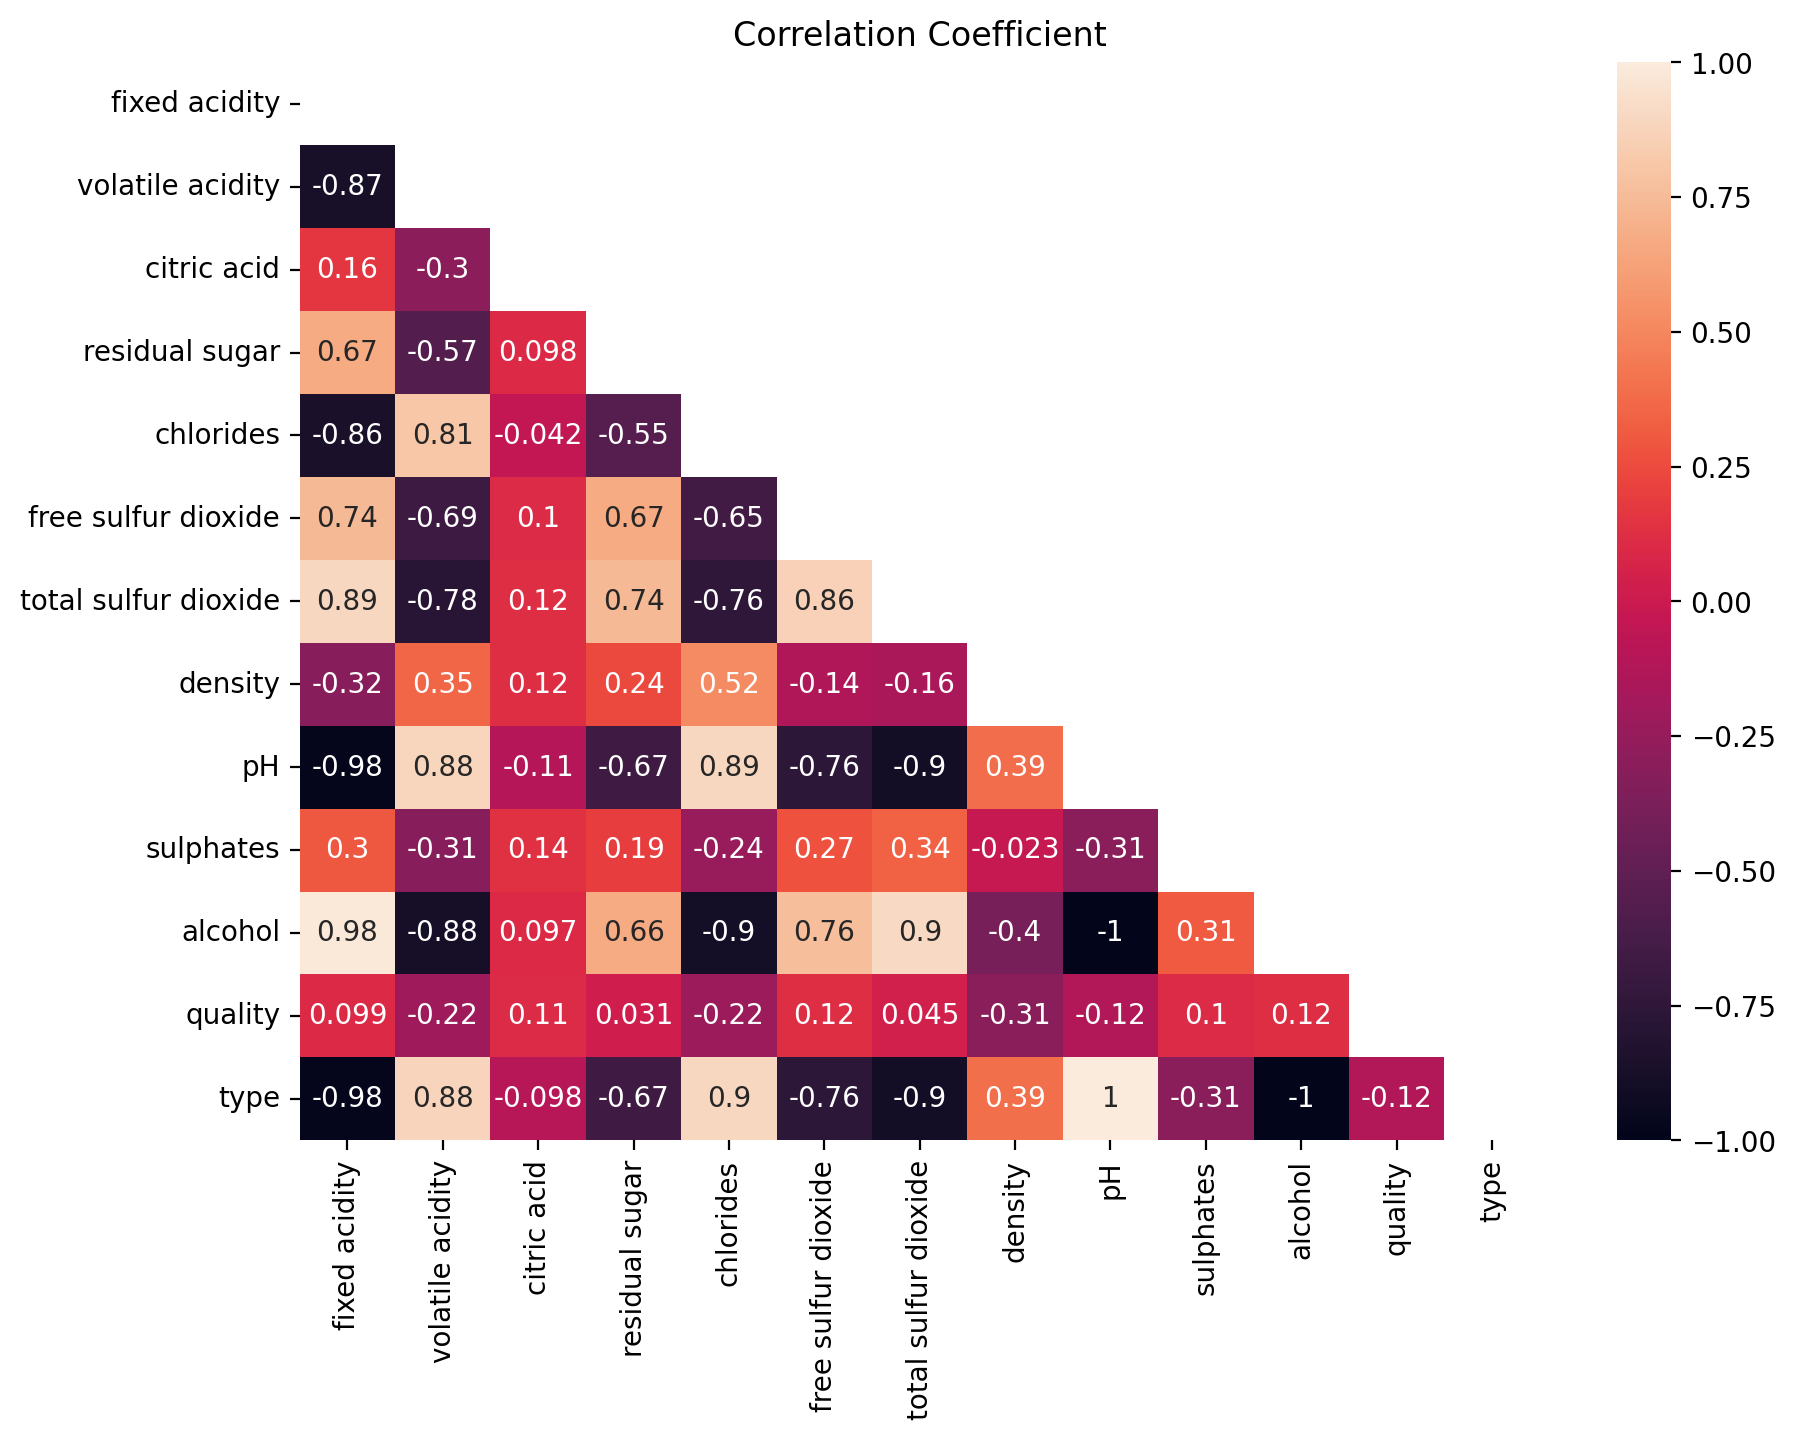

In [5]:
plt.figure(figsize = (10,7))

# mask = np.triu(np.ones_like(df.drop(columns = ["type", "quality"]).corr(), dtype = bool))
mask = np.triu(np.ones_like(df.corr(), dtype = bool))

# sns.heatmap(df.drop(columns = ["type", "quality"]).corr(), annot = True, mask = mask, vmin = -1, vmax = 1)
sns.heatmap(df.corr(), annot = True, mask = mask, vmin = -1, vmax = 1)
plt.title('Correlation Coefficient')
plt.show()

In [6]:
def cal_vif(considered_features):
    
    X = df[considered_features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable'] != 'intercept']
    return vif

In [7]:
considered_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                       'pH', 'sulphates', 'alcohol']  ## No calculating VIF of "type" & "quality"

print(cal_vif(considered_features).sort_values("VIF", ascending = False))

considered_features.remove("alcohol")
print('')
print(cal_vif(considered_features).sort_values("VIF", ascending = False))

considered_features.remove("pH")
print('')
print(cal_vif(considered_features).sort_values("VIF", ascending = False))

considered_features.remove("fixed acidity")
print('')
print(cal_vif(considered_features).sort_values("VIF", ascending = False))

considered_features.remove("total sulfur dioxide")
print('')
print(cal_vif(considered_features).sort_values("VIF", ascending = False))

                Variable          VIF
10               alcohol  1441.899448
8                     pH  1355.959802
0          fixed acidity    28.739811
6   total sulfur dioxide    11.249402
4              chlorides     6.980826
1       volatile acidity     5.995035
3         residual sugar     4.787268
7                density     4.427466
5    free sulfur dioxide     4.153243
2            citric acid     1.618318
9              sulphates     1.195247

               Variable        VIF
8                    pH  49.221309
0         fixed acidity  28.211121
6  total sulfur dioxide  11.186047
4             chlorides   6.738881
1      volatile acidity   5.994990
3        residual sugar   4.683744
5   free sulfur dioxide   4.153211
7               density   4.054838
2           citric acid   1.412690
9             sulphates   1.187538

               Variable        VIF
0         fixed acidity  10.398484
6  total sulfur dioxide   9.949991
4             chlorides   6.626755
1      volatile a

## SequentialFeatureSelector

In [8]:
X = df.drop(columns = ["type", "quality"])
type = df["type"]
qua = df["quality"]

sfs = SFS(
    cv = 5,
    estimator = LogisticRegression(),
    forward = True,
    k_features = "best",
    scoring = "accuracy",
    n_jobs = -1,
    verbose = 0
)

## Type SFS
sfs.fit(X, type)
print(sfs.k_feature_names_)
print(sfs.k_score_)

## Quality
sfs.fit(X, qua)
print(sfs.k_feature_names_)
print(sfs.k_score_)

('fixed acidity',)
1.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

('volatile acidity', 'citric acid', 'residual sugar', 'free sulfur dioxide')
0.44420335169064956


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_